In [2]:
import numpy as np
import pickle
import json

# Load the edge index
edge_index = np.loadtxt("Graph-SST2/raw/Graph-SST2_edge_index.txt", dtype=int)

# Load the graph labels (targets)
graph_labels = np.loadtxt("Graph-SST2/raw/Graph-SST2_graph_labels.txt", dtype=int)

# Load node features
with open("Graph-SST2/raw/Graph-SST2_node_features.pkl", "rb") as f:
    node_features = pickle.load(f)

# Load the node indicator (which graph each node belongs to)
node_indicator = np.loadtxt("Graph-SST2/raw/Graph-SST2_node_indicator.txt", dtype=int)

# Load the sentence tokens (optional, only if you need them)
with open("Graph-SST2/raw/Graph-SST2_sentence_tokens.json") as f:
    sentence_tokens = json.load(f)

# Load the split indices
split_indices = np.loadtxt("Graph-SST2/raw/Graph-SST2_split_indices.txt", dtype=int)

In [6]:
from random import sample
import random
import networkx as nx

# Assuming you have 2 classes (0 and 1)
class_0_indices = np.where(graph_labels == 0)[0]
class_1_indices = np.where(graph_labels == 1)[0]

# Randomly sample 5 prototype graphs from each class
prototype_class_0 = sample(list(class_0_indices), 5)
prototype_class_1 = sample(list(class_1_indices), 5)

# Combine the prototypes
prototypes = {0: prototype_class_0, 1: prototype_class_1}

In [8]:
from custom.utils import *

In [13]:
import networkx as nx
import random
import numpy as np


def perturb_graph(edge_index, node_indicator, prototype_idx, num_perturbations=20):
    perturbed_graphs = []

    # Get the nodes that belong to the prototype graph
    prototype_nodes = np.where(node_indicator == prototype_idx)[0]

    # Filter edges where both nodes belong to the prototype graph
    mask = np.isin(edge_index[0], prototype_nodes) & np.isin(
        edge_index[1], prototype_nodes
    )
    prototype_edges = edge_index[:, mask]

    # Create a graph for the prototype in NetworkX format (undirected by default)
    G = nx.Graph()
    G.add_edges_from(prototype_edges.T)

    for _ in range(num_perturbations):
        # Create a copy of the original graph to perturb
        G_perturbed = G.copy()

        # Randomly remove or add some edges/nodes
        for _ in range(random.randint(1, 5)):  # 1 to 5 perturbations
            if random.random() > 0.5:
                # Randomly remove an edge if there are edges to remove
                if len(G_perturbed.edges) > 0:
                    edge_to_remove = random.choice(list(G_perturbed.edges))
                    G_perturbed.remove_edge(*edge_to_remove)
            else:
                # Randomly add a new undirected edge between existing nodes
                node_a = random.choice(prototype_nodes)
                node_b = random.choice(prototype_nodes)
                if node_a != node_b and not G_perturbed.has_edge(node_a, node_b):
                    G_perturbed.add_edge(node_a, node_b)

        # Append the perturbed graph (still in NetworkX format)
        perturbed_graphs.append(G_perturbed)

    return perturbed_graphs


# Generate perturbed versions for each prototype in NetworkX format
perturbed_graphs_class_0 = [
    perturb_graph(edge_index, node_indicator, idx, num_perturbations=20)
    for idx in prototype_class_0
]

perturbed_graphs_class_1 = [
    perturb_graph(edge_index, node_indicator, idx, num_perturbations=20)
    for idx in prototype_class_1
]

# Now you have lists of perturbed undirected NetworkX graphs for both classes

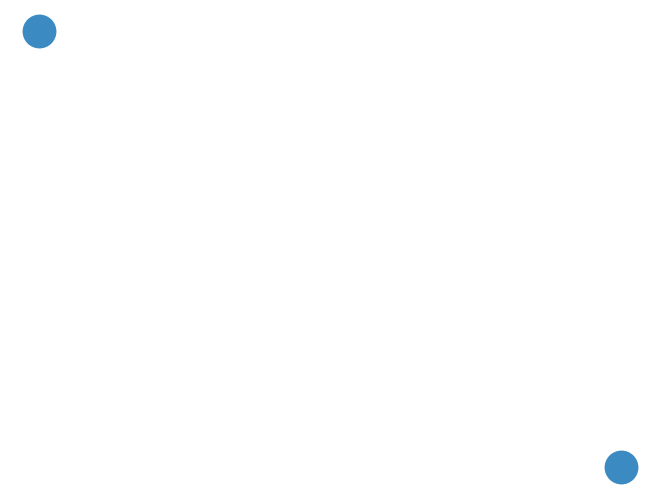

In [16]:
nx.draw(
    (perturbed_graphs_class_0[0][1]),
    with_labels=False,
    node_color="#3b8bc2",
    node_size=500,
    edge_color="k",
    linewidths=2,
    font_size=15,
)